# Adult income dataset

## 1. Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('weatherHistory_v1.csv')
df = df.drop('Loud Cover',axis=1)
df = df.replace('?', np.NaN)

In [3]:
df.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.


In [4]:
df.shape

(31673, 11)

In [5]:
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
count,31673.000000,31673.000000,31673.000000,31673.000000,31673.000000,31673.000000,31673.000000
mean,11.827759,10.696333,0.717913,10.863263,191.154043,10.101612,1000.488707
std,9.701925,10.822214,0.193024,6.965879,106.224840,3.756429,129.768310
min,-16.666667,-24.233333,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.388889,1.988889,0.590000,5.796000,121.000000,9.708300,1011.820000
50%,11.577778,11.577778,0.770000,9.885400,189.000000,9.982000,1016.650000
75%,18.888889,18.888889,0.870000,14.248500,290.000000,11.270000,1021.790000
max,39.905556,38.377778,1.000000,63.852600,359.000000,16.100000,1046.380000


In [6]:
df.isna().sum()

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

In [7]:
df[df['Precip Type'].isna()].Summary.unique()

array([], dtype=object)

In [8]:
df = df.dropna()

In [9]:
df.dtypes

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

In [10]:
df['Formatted Date'] = pd.Categorical(df['Formatted Date'])
df['Summary'] = pd.Categorical(df['Summary'])
df['Precip Type'] = pd.Categorical(df['Precip Type'])
df['Daily Summary'] = pd.Categorical(df['Daily Summary'])

## 2.Visualization

In [11]:
df_for_viz = df.copy()
for column in df_for_viz.select_dtypes(include='category').columns:
    df_for_viz[column] = df_for_viz[column].cat.codes

### All-vs-All correlation

<AxesSubplot:>

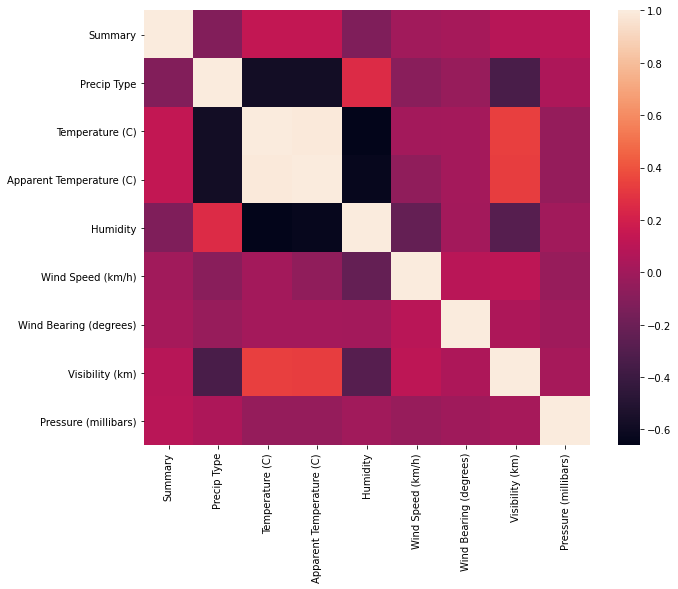

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(df_for_viz.corr())

### Distribution plots

In [13]:
fig, axes = plt.subplots(nrows=11, ncols=1,figsize=(20,100))
fig.tight_layout(pad=10.0)
ax_iter = iter(axes.flat)
for column in df.columns:
    ax = next(ax_iter)
    if column in ('Temperature (C)', 'Apparent Temperature (C)'):
        ax.tick_params(labelrotation=90)
    a = sns.histplot(df[column],ax=ax)

TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


### Boxplots conditioned on label

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,20))
ax_iter = iter(axes.flat)
for column in ['age', 'educational-num', 'hours-per-week']:
    ax = next(ax_iter)
    a = sns.boxplot(x='income', y=column, data=df,ax=ax)

## 3. ML Time

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

### One-Hot encoding

In [16]:
for column in df.select_dtypes(include='category').columns:
    if column=='income':
        continue
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)],axis=1)
    df.drop([column],axis=1, inplace=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income',axis=1), df['income'].cat.codes, test_size=0.2, random_state=42)

### Numerical features scaling

In [18]:
for column in df.select_dtypes(include='int64').columns:
    scale = StandardScaler().fit(X_train[[column]])
    X_train[[column]] = scale.transform(X_train[[column]])
    X_test[[column]] = scale.transform(X_test[[column]])

### KNN

In [19]:
n_neighbors = list(range(10,15))
hyperparameters = dict(n_neighbors=n_neighbors)
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, hyperparameters, cv=3, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.4min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.4min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.4min remaining:   36.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.5min finished


Best n_neighbors: 12


In [20]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [21]:
knn.score(X_test, y_test)

0.8436705362078496

In [22]:
f1_score(y_test, y_pred, average='binary')

0.6381780962128966

### Decision Tree

In [23]:
max_depth = [None,5,10,15]
hyperparameters = dict(max_depth=max_depth)
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, hyperparameters, cv=3, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.0s finished


Best max_depth: 10


In [24]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
print('Score:', dtc.score(X_test, y_test))
print(f1_score(y_test, y_pred, average='binary'))

Score: 0.859812050856827
0.6687565308254964


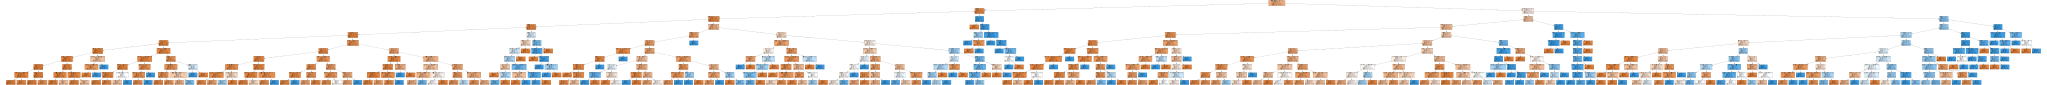

In [25]:
import graphviz
dot_data = export_graphviz(dtc, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['income<=50K','income>50K'],
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

### SVM

In [26]:
c = [0.1, 1, 2]
gamma = [0.1, 0.5]
kernel = ['rbf']
hyperparameters = dict(C=c, gamma=gamma, kernel=kernel)
svc = SVC()
clf = GridSearchCV(svc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  1.7min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  3.0min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.4min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  4.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.6min finished


Best C: 2
Best gamma: 0.1
Best kernel: rbf


In [27]:
svc = SVC(C=2, kernel='rbf', gamma=0.1)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

In [28]:
svc.score(X_test, y_test)

0.8606965174129353

In [29]:
f1_score(y_test, y_pred, average='binary')

0.6837349397590361

### Random Forest

In [32]:
n_estimators = [5, 10, 100, 200, 500]
max_depth = [None, 5, 10,15,20,25]
min_samples_split = [0.1,0.25,0.5,1,2]
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Best n_estimators: 500
Best max_depth: 20
Best min_samples_split: 2


In [33]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=2)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.8666666666666667

In [34]:
f1_score(y_test, y_pred, average='binary')

0.6921898928024502

### AdaBoost

In [37]:
n_estimators = [10, 50, 100, 500]
learning_rate = [0.1, 0.5, 1, 2, 5, 10]
algorithm = ['SAMME', 'SAMME.R']
hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm)
abc = AdaBoostClassifier()
clf = GridSearchCV(abc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:  1.4min remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.4min finished


Best n_estimators: 500
Best learning_rate: 1
Best algorithm: SAMME.R


In [38]:
abc = AdaBoostClassifier(n_estimators=500, learning_rate=1, algorithm='SAMME.R')
abc.fit(X_train,y_train)
y_pred = abc.predict(X_test)
abc.score(X_test, y_test)

0.8707573244886678

In [39]:
f1_score(y_test, y_pred, average='binary')

0.7044247787610619

### Gradient Boost

In [41]:
learning_rate = [0.01, 0.1, 0.5]
n_estimators = [100, 250, 500]
max_depth = [3, 5, 7]
hyperparameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
gbc = GradientBoostingClassifier()
clf = GridSearchCV(gbc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:  3.5min remaining:   41.8s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:  3.8min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.2min finished


Best learning_rate: 0.1
Best n_estimators: 500
Best max_depth: 3


In [42]:
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=3)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
gbc.score(X_test, y_test)

0.875069098949696

In [43]:
f1_score(y_test, y_pred, average='binary')

0.7167919799498748

# Best model by f1-score - GradientBoostingClassifier

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6842
           1       0.80      0.65      0.72      2203

    accuracy                           0.88      9045
   macro avg       0.85      0.80      0.82      9045
weighted avg       0.87      0.88      0.87      9045



In [53]:
print(confusion_matrix(y_test, y_pred))

[[6485  357]
 [ 773 1430]]
